In [246]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
import numpy as np
import matplotlib.pyplot as plt

import dedalus.public as d3

import logging
logger = logging.getLogger(__name__)

# Nongeostrophic linear stability calculations for steady 1D sloping bottom mixing layers (SBML)

In [248]:
# parameters
N = 1.e-3 # buoyancy frequency
f = -5.5e-5 # Coriolis parameter
θ = 2.e-3 # slope angle

κ0 = 1.e-5 # background diffusivity
κ1 = 1.e-3 # bottom enhancement of diffusivity
h = 200. # decay scale of mixing
σ = 1 # Prandtl number

H = 2500. # domain height

### Setup numerical coordinates and grid for Dedalus (interpretive differential equation solver)

In [249]:
## Coordinates and basis
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.complex128)

nz = 256 # number of grid points
zbasis = d3.Chebyshev(zcoord, size=nz, bounds=(0, H), dealias=3/2)

## Solve the 1D SBML Linear Boundary Value Problem (LBVP)

### Setup variables and non-constant coefficients for the 1D SBML LBVP

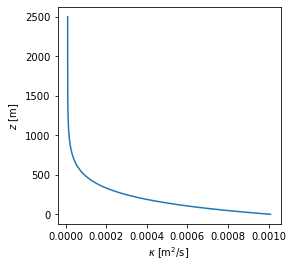

In [250]:
## Fields

# state variables
B = dist.Field(name='B', bases=zbasis)
U = dist.Field(name='U', bases=zbasis)
V = dist.Field(name='V', bases=zbasis)

# non-constant coefficients
κ = dist.Field(name='κ', bases=zbasis)
z = dist.local_grid(zbasis)
κ['g'] = κ0 + κ1*np.exp(-z/h)

plt.figure(figsize=(4,4))
plt.plot(κ.data.real, z)
plt.xlabel(r"$\kappa$ [m$^{2}$/s]")
plt.ylabel(r"$z$ [m]");

Boundary conditions are numerically enforced using the "tau method", which requires additional polynomial terms be included to the equation sets (one per boundary condition).

In [251]:
# boundary conditions (tau method)
τ_B = dist.Field(name="τ_B")
τ_U = dist.Field(name="τ_U")
τ_V = dist.Field(name="τ_V")

τ_Bz = dist.Field(name="τ_Bz")
τ_Uz = dist.Field(name="τ_Uz")
τ_Vz = dist.Field(name="τ_Vz")

Variable substitutions facilitate the symbolic representation of differential operations (and their corrresponding tau terms) and constants.

In [252]:
# substitutions
dz = lambda A: d3.Differentiate(A, zcoord)

cosθ = np.cos(θ)
sinθ = np.sin(θ)
N2 = N**2

lift_basis = zbasis.clone_with(a=1/2, b=1/2) # First derivative basis
lift = lambda A: d3.Lift(A, lift_basis, -1)
Uz = dz(U) + lift(τ_Uz)
Vz = dz(V) + lift(τ_Vz)
Bz = dz(B) + lift(τ_Bz)

noflux = dist.Field(name='noflux')
noflux['g'] = -N2*cosθ

### Setup the LBVP and add equations and boundary conditions

In [253]:
problem = d3.LBVP([U, V, B, τ_U, τ_V, τ_B, τ_Uz, τ_Vz, τ_Bz], namespace=locals())

# Equation set
problem.add_equation("-f*V*cosθ - B*sinθ - σ*dz(κ*Uz) + lift(τ_U) = 0")
problem.add_equation("f*U*cosθ - σ*dz(κ*Vz) + lift(τ_V) = 0")
problem.add_equation("U*N2*sinθ - dz(κ*Bz) + lift(τ_B) = dz(κ)*N2*cosθ")

# Boundary conditions
problem.add_equation('U(z=0) = 0')
problem.add_equation('V(z=0) = 0')
problem.add_equation('dz(B)(z=0) = noflux')
problem.add_equation('dz(U)(z=H) = 0')
problem.add_equation('dz(V)(z=H) = 0')
problem.add_equation('dz(B)(z=H) = 0')

# build solver (i.e. setup matrices for solution method)
solver = problem.build_solver()

# solve problem
solver.solve()

2022-02-16 16:22:53,571 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


Verify the solution by comparing against [Callies' (2018)](https://journals.ametsoc.org/view/journals/phoc/48/9/jpo-d-18-0082.1.xml) asymptotic analytical solution (valid here since $\delta \ll h$). 

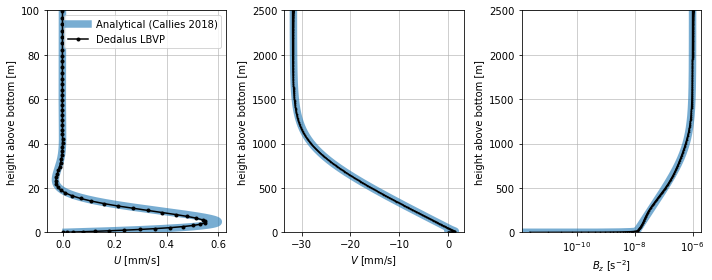

In [254]:
from bml_1d_LBVP_approx import *
bml = bbl_exp(k0=κ0, k1=κ1, h=h, N=N, f=f, θ=θ, H=H, dz=0.1)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(bml['u']*1e3, bml['z'], label="Analytical (Callies 2018)", lw=7.5, alpha=0.6)
plt.plot(U['g'].real*1e3, z, "k.-", label="Dedalus LBVP")
plt.ylim(0, 100)
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$U$ [mm/s]")
plt.grid(True, alpha=0.75)
plt.legend()

plt.subplot(1,3,2)
plt.plot(bml['v']*1e3, bml['z'], label="Analytical (Callies 2018)", lw=7.5, alpha=0.6)
plt.plot(V['g'].real*1e3, z, "k.-", markersize=1., label="Dedalus LBVP")
plt.ylim(0, H)
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$V$ [mm/s]")
plt.grid(True, alpha=0.75)

plt.subplot(1,3,3)
plt.plot(bml['Bz'], bml['zf'], label="Analytical (Callies 2018)", lw=7.5, alpha=0.6)
plt.plot(np.diff(B['g'].real)/np.diff(z) + N2*np.cos(θ), 0.5*(z[1:]+z[:-1]), "k.-", markersize=1., label="Dedalus LBVP")
plt.ylim(0, H)
plt.xscale("log")
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$B_{z}$ [s$^{-2}$]")
plt.grid(True, alpha=0.75)
plt.grid(True, which="minor", alpha=0.3)

plt.tight_layout()

## Solve the 3D Eigen-Value Problem (EVP) for small perturbations relative to the steady 1D SBML basic state

We begin by illustrating the method of finding the maximum eigenvalue (growth rate) for a single pair normal modes (chosen to be close to the fastest-growing baroclinic mode).

We linearize the sloping Boussinesq equations relative to the 1D basic state shown above. We consider solutions $\phi(z) \propto \exp\{i(kx + ly - \omega t)\}$ with normal mode structures in $x$ and $y$ and with slope-normal $z$ structure to be determined.

If $\Im \{ \omega \}>0$, then the perturbation will grow exponentially; conversely, any $\Im \{ \omega \}<0$ modes decay exponentially over time. Any $\Re\{ \omega \} \neq 0$ component is oscillatory. 

We are interested in the eigenvalues/vectors with the *largest positive imaginary component*, since these will be the relevant growth rate and modal structures.

#### Setup and solve the EVP

Note that in an extremely convenient property of Dedalus is that the same parameters, coefficients, and variables can be reused from the LBVP above in the EVP below! This dramatically simplifies the problems setup!

2022-02-16 16:22:59,854 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 2.8e-01/s


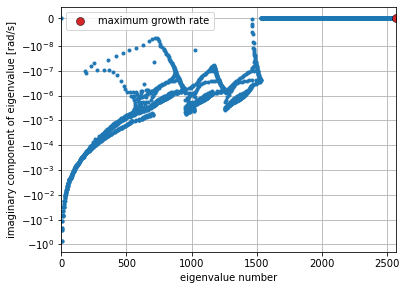

In [255]:
k=0
l=2e-4

# LINEAR STABILITY ANALYSIS

# variables
b = dist.Field(name='b', bases=zbasis)
u = dist.Field(name='u', bases=zbasis)
v = dist.Field(name='v', bases=zbasis)
w = dist.Field(name='w', bases=zbasis)
p = dist.Field(name='p', bases=zbasis)

# boundary condition fields (via tau method)
τ_b = dist.Field(name="τ_b")
τ_u = dist.Field(name="τ_u")
τ_v = dist.Field(name="τ_v")
τ_w = dist.Field(name="τ_w")
τ_p = dist.Field(name="τ_p")

τ_bz = dist.Field(name="τ_bz")
τ_uz = dist.Field(name="τ_uz")
τ_vz = dist.Field(name="τ_vz")
τ_wz = dist.Field(name="τ_wz")

# eigenvalues
ω = dist.Field(name="ω")

# substitutions
dx = lambda ϕ: 1j*k*ϕ
dy = lambda ϕ: 1j*l*ϕ
dt = lambda ϕ: -1j*ω*ϕ
integ = lambda A: d3.Integrate(A, 'z')

## How should I be setting these?
lift_basis = zbasis.clone_with(a=1/2, b=1/2) # First derivative basis
lift = lambda A: d3.Lift(A, lift_basis, -1)

# First-order reductions
uz = dz(u) + lift(τ_uz)
vz = dz(v) + lift(τ_vz)
wz = dz(w) + lift(τ_wz)
bz = dz(b) + lift(τ_bz)

# setup problem
problem = d3.EVP(
    [u, v, w, b, p, # perturbation variables
     τ_u, τ_v, τ_w, τ_b, τ_p, τ_uz, τ_vz, τ_wz, τ_bz], # taus for enforcing boundary conditions
    eigenvalue=ω,
    namespace=locals()
)
problem.add_equation(# Cross-slope momentum
    'dt(u) + w*dz(U) + U*dx(u) + V*dy(u) - f*v*cosθ + dx(p)'
    '- b*sinθ - σ*dz(κ*uz)'
    '+ lift(τ_u) = 0'
)
problem.add_equation((# Along-slope momentum
    'dt(v) + w*dz(V) + U*dx(v) + V*dy(v) + f*(u*cosθ - w*sinθ) + dy(p)'
    '- σ*dz(κ*vz)'
    '+ lift(τ_v) = 0'
))
problem.add_equation((# Slope-normal momentum
    'dt(w) + U*dx(w) + V*dy(w) + f*v*sinθ + dz(p)'
    '- b*cosθ - σ*dz(κ*wz)'
    '+ lift(τ_w) = 0'
))
problem.add_equation((# Buoyancy
    'dt(b) + u*N2*sinθ + w*N2*cosθ + w*dz(B) + U*dx(b) + V*dy(b)'
    '- dz(κ*bz)'
    '+ lift(τ_b) = 0'
))
problem.add_equation('dx(u) + dy(v) + wz + τ_p = 0')

problem.add_equation('u(z=0) = 0')
problem.add_equation('v(z=0) = 0')
problem.add_equation('w(z=0) = 0')
problem.add_equation('dz(b)(z=0) = 0')

problem.add_equation('dz(u)(z=H) = 0')
problem.add_equation('dz(v)(z=H) = 0')
problem.add_equation('w(z=H)*cosθ + u(z=H)*sinθ = 0') # vanishing vertical (not slope-normal) velocity
problem.add_equation('dz(b)(z=H) = 0')

problem.add_equation("integ(p) = 0") # Pressure gauge

# set up solver
solver = problem.build_solver()

# solve the EVP
solver.solve_dense(solver.subproblems[0])

# sort eigenvalues
omega = np.copy(solver.eigenvalues)
omega[np.isnan(omega)] = 0.
omega[np.isinf(omega)] = 0.
idx = np.argsort(omega.imag)[-1] # sorts from small to large

plt.figure(figsize=(6, 4.5))
plt.plot(omega.imag, ".")
plt.yscale("symlog", linthresh=1e-8)

plt.grid(True)
plt.grid(True, which="minor", alpha=0.2)
plt.xlabel("eigenvalue number")
plt.ylabel("imaginary component of eigenvalue [rad/s]")
plt.xlim(0, nz*5+9)
plt.plot(range(omega.size)[idx], omega.imag[idx],
        "C3o", markersize=8, label="maximum growth rate",
        markeredgecolor="k", markeredgewidth=0.5
)
plt.legend();

#### Work in progress: visualizing the structure of the fastest-growing perturbations (and their covariances, which do not necessarily vanish under phase-averaging)

In [221]:
solver.set_state(idx, solver.subsystems[0])